In [278]:
import pickle
import numpy as np
import pandas as pd
from keras import models
from keras.layers import Dense, Concatenate, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
import time
import os
import sys
import CNN_functions as CNNFuncs

In [279]:
### Dataset Parameters
######################
test_size = 0.2
random_state = 1
model_mode = "depmap"
GOIs_mode = "top100"
extract_genes_no = 4000
extract_neg_selec = False

### Model Parameters
####################
activation_func = 'relu' 
activation_func2 = 'linear'
kernel_initializer = 'he_uniform'
dense_layer_dim = 500
l2_reg = None
batch_size = 250
num_epoch = 250


In [280]:
model_datasets, tRCC_datasets, essential_genes = CNNFuncs.preprocess_data(test_size=test_size,
                                                                          random_state=random_state,
                                                                          mode=model_mode,
                                                                          extract_top_genes=extract_genes_no,
                                                                          extract_neg_selec=extract_neg_selec)

X_train = model_datasets[0]
Y_train = model_datasets[2]

X_test = model_datasets[1]
Y_test = model_datasets[3]

tRCC_gene_exp = tRCC_datasets[0]
tRCC_gene_effect = tRCC_datasets[1]

top100_essential_genes = essential_genes["top100_essential_genes"]
top_common_essential_genes = essential_genes["common_essential_genes"]

DepMap dataset row/column check:  {'all_match': True, 'column_differences': [[], []], 'row_differences': [[], []]}
tRCC dataset row/column check:  {'all_match': True, 'column_differences': [[], []], 'row_differences': [[], []]}
Check columns across DepMap and tRCC dataframes:  {'all_match': True, 'column_differences': [[], [], [], []]}


In [281]:
model = models.Sequential()
model.add(Dense(500, input_dim=X_train.shape[1], activation=activation_func, kernel_initializer=kernel_initializer, kernel_regularizer=l2(l2_reg) if l2_reg != None else None))
model.add(Dense(300, activation=activation_func, kernel_initializer=kernel_initializer, kernel_regularizer=l2(l2_reg) if l2_reg != None else None))
model.add(Dense(150, activation=activation_func, kernel_initializer=kernel_initializer, kernel_regularizer=l2(l2_reg) if l2_reg != None else None))
model.add(Dense(75, activation=activation_func, kernel_initializer=kernel_initializer, kernel_regularizer=l2(l2_reg) if l2_reg != None else None))
model.add(Dense(dense_layer_dim, activation=activation_func, kernel_initializer=kernel_initializer, kernel_regularizer=l2(l2_reg) if l2_reg != None else None))
model.add(Dense(dense_layer_dim, activation=activation_func, kernel_initializer=kernel_initializer, kernel_regularizer=l2(l2_reg) if l2_reg != None else None))
model.add(Dense(dense_layer_dim, activation=activation_func, kernel_initializer=kernel_initializer, kernel_regularizer=l2(l2_reg) if l2_reg != None else None))
model.add(Dense(dense_layer_dim, activation=activation_func, kernel_initializer=kernel_initializer, kernel_regularizer=l2(l2_reg) if l2_reg != None else None))
model.add(Dense(Y_train.shape[1], activation=activation_func2, kernel_initializer=kernel_initializer, kernel_regularizer=l2(l2_reg) if l2_reg != None else None))

model.compile(loss='mse', optimizer='adam') 

t = time.time()

early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min')
history = model.fit(X_train, Y_train, epochs=num_epoch, validation_split=1/9, batch_size=batch_size, shuffle=True, callbacks=[early_stopping_callback])

cost_testing = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)

loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print("\n\nModel training completed in %.1f mins.\nloss:%.4f valloss:%.4f testloss:%.4f" % ((time.time() - t)/60, loss, val_loss, cost_testing))

Epoch 1/250
2/2 [==============================] - 0s 93ms/step - loss: 40.8559 - val_loss: 18.9119
Epoch 2/250
2/2 [==============================] - 0s 33ms/step - loss: 16.5225 - val_loss: 4.8405
Epoch 3/250
2/2 [==============================] - 0s 33ms/step - loss: 4.3019 - val_loss: 2.2166
Epoch 4/250
2/2 [==============================] - 0s 34ms/step - loss: 2.0045 - val_loss: 1.1360
Epoch 5/250
2/2 [==============================] - 0s 35ms/step - loss: 1.0932 - val_loss: 0.9154
Epoch 6/250
2/2 [==============================] - 0s 33ms/step - loss: 0.8947 - val_loss: 0.8047
Epoch 7/250
2/2 [==============================] - 0s 33ms/step - loss: 0.8063 - val_loss: 0.7855
Epoch 8/250
2/2 [==============================] - 0s 33ms/step - loss: 0.7869 - val_loss: 0.7624
Epoch 9/250
2/2 [==============================] - 0s 34ms/step - loss: 0.7632 - val_loss: 0.7366
Epoch 10/250
2/2 [==============================] - 0s 33ms/step - loss: 0.7359 - val_loss: 0.6942
Epoch 11/250
2/2

In [282]:
predictions = pd.DataFrame(model.predict(X_test), columns=X_test.columns, index=X_test.index)

7/7 [==============================] - 0s 3ms/step


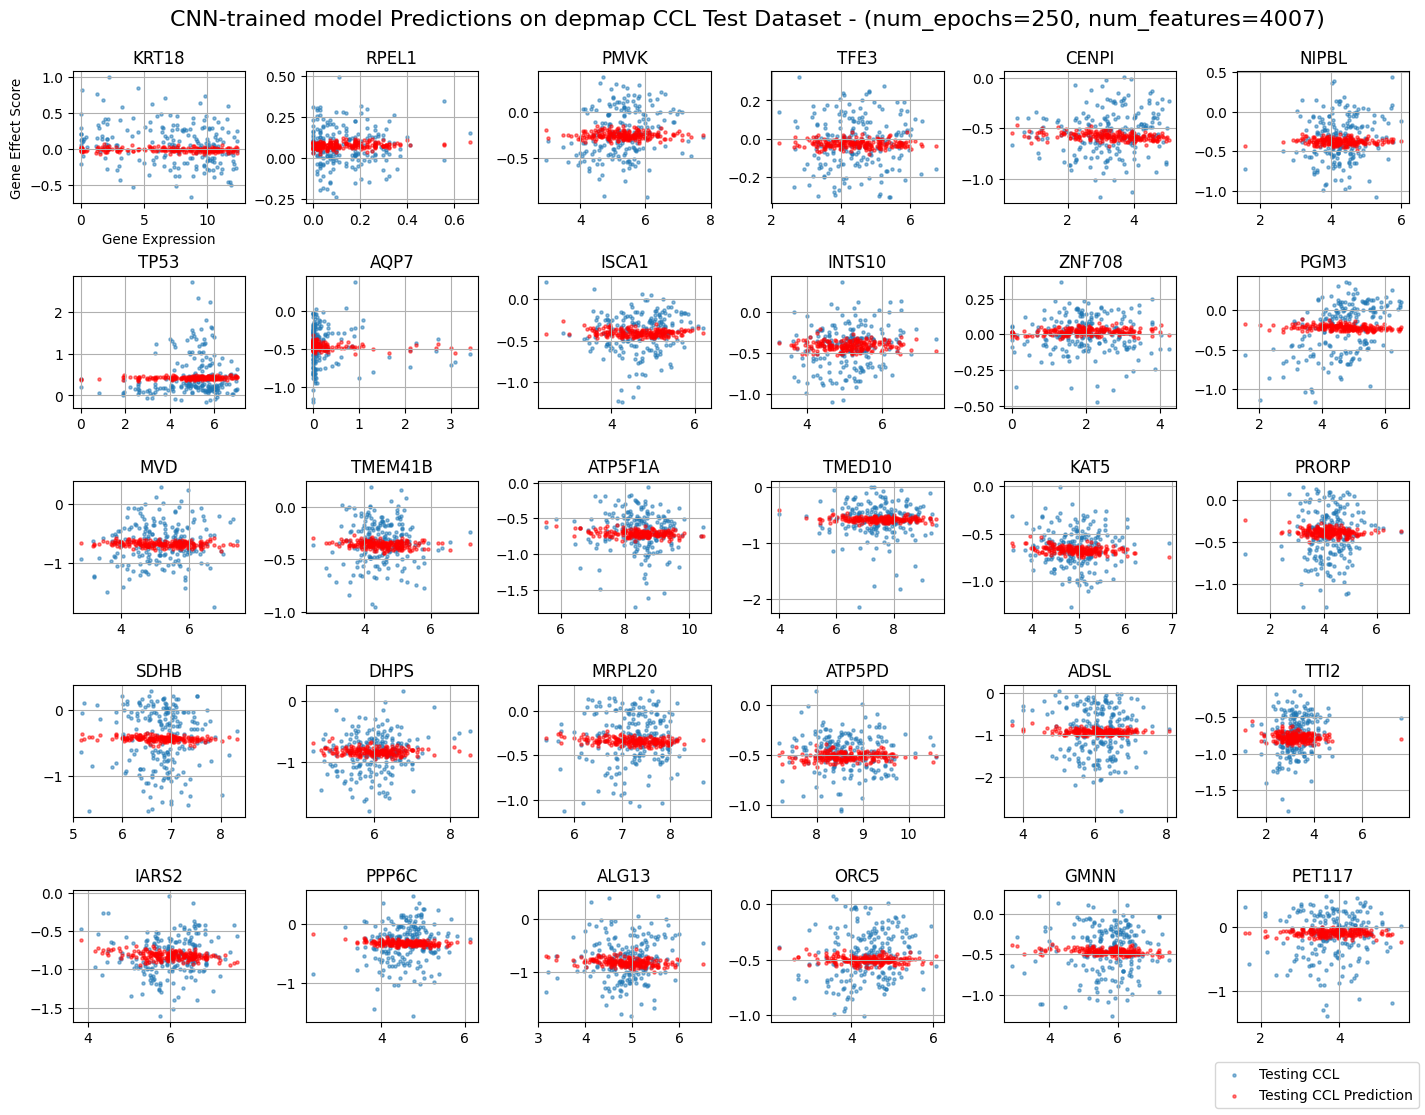

In [314]:
CNNFuncs.GeneRelMiniPlot(X_test, Y_test, top100_essential_genes[:30].to_list(),
                         rel2_X=X_test,
                         rel2_Y=predictions,
                         main_title="CNN-trained Model Predictions on {0} CCL Test Dataset - (num_epochs={1}, num_features={2})".format(model_mode, num_epoch, X_train.shape[1]),
                         axes_labels=["Gene Expression", "Gene Effect Score"],
                         axis_label_fontsize=9.75,
                         legend_titles={"rel1": "Testing CCL", "rel2": "Testing CCL Prediction"},
                                        sizeProps=[0.925, 0.08, 0.99, 0],
                                        wspace=0.35,
                                        hspace=0.55)

In [284]:
pred_RMSE_top100_essential_genes = CNNFuncs.PredGeneRMSE(Y_test, predictions, top100_essential_genes)

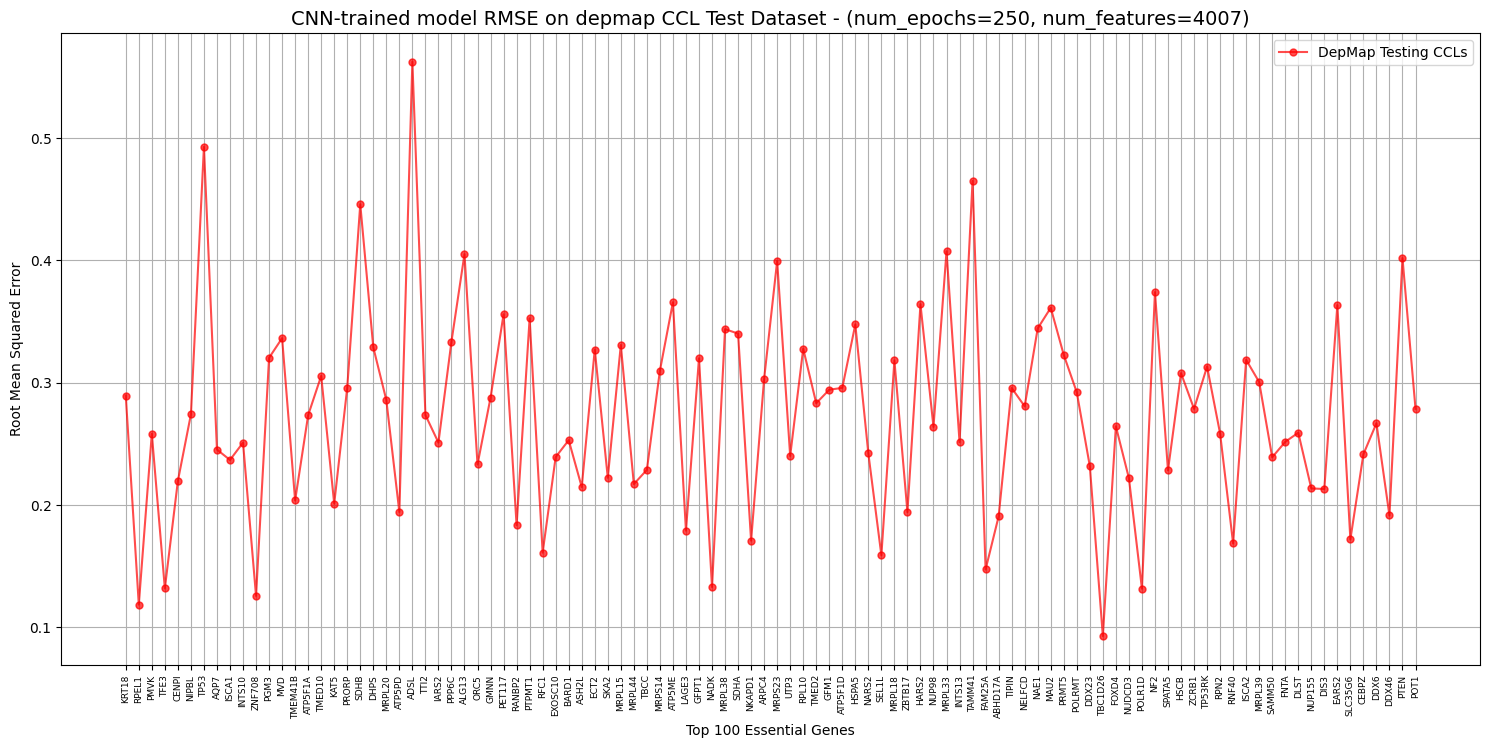

In [315]:
CNNFuncs.LinePlot(pred_RMSE_top100_essential_genes, 
            {"RMSE": "red"}, 
            axes_labels=["Top 100 Essential Genes", 
                         "Root Mean Squared Error"], 
            main_title="CNN-trained Model RMSE on {0} CCL Test Dataset - (num_epochs={1}, num_features={2})".format(model_mode, num_epoch, X_train.shape[1]),
            legend_titles={"RMSE": "{0} Testing RMSE".format(model_mode)})

In [286]:
print("Average RMSE for predicted gene effect scores on testing subset of CCLs: {0:.4}".format(pred_RMSE_top100_essential_genes["RMSE"].mean()))

Average RMSE for predicted gene effect scores on testing subset of CCLs: 0.2739


In [319]:
save_bool = input("Save Model? y/n: ")

if save_bool == "y":
    
    model_name = input("Model Name: ")

    if os.path.exists("models/{0}/{1}".format(model_mode, model_name)):
        raise ValueError("model already exists")
    
    os.mkdir("models/{0}/{1}".format(model_mode, model_name))

    model.save("models/{0}/{1}/model.h5".format(model_mode, model_name))
    print("saved model to {0}".format("models/{0}/{1}/model.h5".format(model_mode, model_name)))

    model_info = {"test_size": test_size,
                  "random_state": random_state,
                  "model_mode": model_mode,
                  "extract_genes_no": extract_genes_no,
                  "extract_neg_selec": extract_neg_selec,
                  "dense_layer_dim": dense_layer_dim,
                  "l2_reg": l2_reg,
                  "num_epoch": num_epoch}
    
    pd.DataFrame.from_dict(model_info, orient='index').to_csv("models/{0}/{1}/model_info".format(model_mode, model_name))

saved model to models/depmap/V3/model.h5


/Users/harshel/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
